# Experimenting with Multivariate LSTM and indices...

I'm reading a datafile with all the REPSOL indices that we were computing using the 9th floor Spark processes. We will try to predict if the vlaue will go 'Up' or 'Down'.

In [1]:
import numpy
import math

import matplotlib.pyplot as plt
from pandas import read_csv, concat, DataFrame
from matplotlib import pyplot
from numpy import concatenate

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## Parameters

In [2]:
num_epochs = 75
look_back = 1
look_forward = 1
training_set_proportion = 0.9
neurons = 46
numpy.random.seed(7)

In [3]:
file = '/Users/renero/Documents/SideProjects/X/indices_calculados_sinfecha.csv'

columNames = ['Price','Up or Down','Volume','High','Low','EMA(Price)',
              'Typical','RMF(in M)','MFR','MFR Index','PVI','EMA(PVI)','NVI','EMA(NVI)',
              'OSCP','RMF','MFI','Bollinger Up','Bollinger Down','bollOsc',
              'gainLoss','RSI','Stochastic Osc']

raw_dataset = read_csv(file, header='infer', delimiter=';', usecols=columNames)
raw_dataset[:5]

,Price,Up or Down,Volume,High,Low,EMA(Price),Typical,RMF(in M),MFR,MFR Index,...,EMA(NVI),OSCP,RMF,MFI,Bollinger Up,Bollinger Down,bollOsc,gainLoss,RSI,Stochastic Osc
0,15.935,1,6369860.0,16.035,15.510,16.554631,1321.03,-8414.75,0.73,42.17,...,1015.96,-11.58,1.000000e+10,42.17,17.58,15.56,-31.40,0.310,42.07,20.68
1,15.760,-1,5519733.0,16.065,15.740,16.475168,1328.37,-7332.27,0.58,36.64,...,1012.61,-10.42,-8.410000e+09,36.64,17.59,15.53,-38.72,-0.175,39.49,12.17
2,15.735,-1,5709738.0,16.140,15.735,16.401151,1332.04,7605.57,0.57,36.48,...,1009.60,-10.49,-7.330000e+09,36.48,17.60,15.50,-38.80,-0.025,39.12,10.95
3,15.990,1,3845771.0,16.100,15.725,16.360036,1349.41,-5189.52,0.57,36.33,...,1008.49,-9.45,7.610000e+09,36.33,17.61,15.50,-26.65,0.255,44.79,23.36
4,15.725,-1,3439957.0,15.990,15.625,16.296532,1309.60,4504.96,0.60,37.34,...,1005.83,-8.50,-5.190000e+09,37.34,17.62,15.46,-37.69,-0.265,40.56,10.46


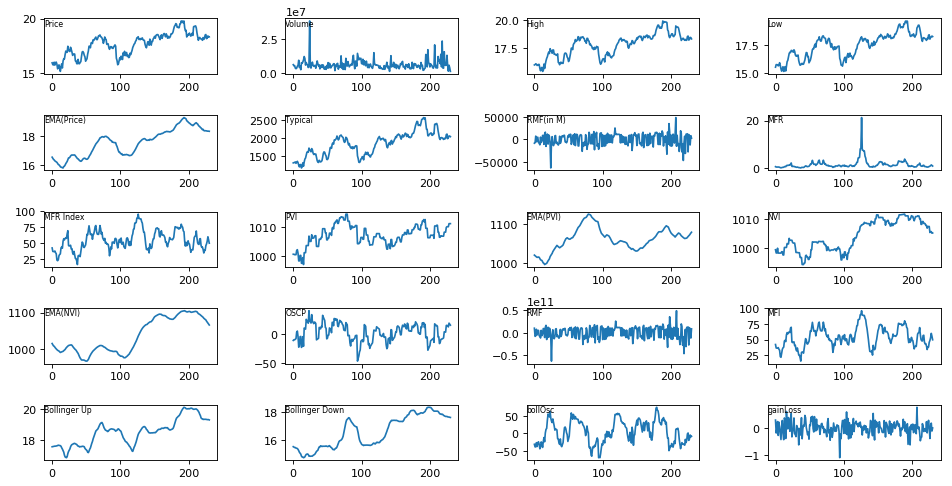

In [4]:
values = raw_dataset.values
# specify columns to plot
groups = [0,2,3,4,5, 6,7,8,9,10, 11,12,13,14,15, 16,17,18,19,20]
i = 1
# plot each column
pyplot.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
num_rows = int(len(groups)/2)
num_cols = int(len(groups)/5)
for group in groups:
    pyplot.subplot(num_rows, num_cols, i)
    pyplot.plot(values[:, group])
    pyplot.title(raw_dataset.columns[group], y=0.75, loc='left', fontsize=7)
    i += 1
pyplot.tight_layout()
pyplot.show()

### Series-To_Supervised

This function is KEY as it produces the array shaped with t-n look-back samples to feed the LSTM

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Scale > Reframe > Drop

Let's make things reproducible. We also convert anything that might not be a float to `float32`. Data in NN is normalized to produce equivalent responses in the different layers. We also do that in this chunk. Then, data is scaled to the range 0..1, reframed according to the syntax in `series-to-supervised` and finally, unuseful columns are removed.

In [6]:
# Data types conversion
dataset = raw_dataset.astype('float32')

# Scale
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

# Reframe
reframed = series_to_supervised(scaled, look_back, look_forward)

# Drop 'num_features - 1' from the tail of each row, as I only want to keep the first one, 
# which will be what I want to predict.
num_features = int(reframed.shape[1] / (look_back + 1))
num_cols = reframed.shape[1]
cols_to_remove = [reframed.columns[col_idx] for col_idx in range(num_cols - num_features + 1, num_cols)]
prepared_dataset = reframed.drop(cols_to_remove, axis=1)

print(prepared_dataset[:5])

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.170442        1.0   0.133267   0.127374   0.083426   0.214102   
2   0.132686        0.0   0.110118   0.134078   0.134594   0.191558   
3   0.127292        0.0   0.115292   0.150838   0.133482   0.170558   
4   0.182308        1.0   0.064537   0.141899   0.131257   0.158893   
5   0.125135        0.0   0.053486   0.117318   0.109010   0.140875   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)    ...     var15(t-1)  \
1   0.100375   0.490949   0.025653    0.329435    ...       0.410212   
2   0.105660   0.500462   0.018527    0.259902    ...       0.423703   
3   0.108303   0.631743   0.018052    0.257890    ...       0.422889   
4   0.120810   0.519294   0.018052    0.256004    ...       0.434985   
5   0.092145   0.604493   0.019477    0.268704    ...       0.446034   

   var16(t-1)  var17(t-1)  var18(t-1)  var19(t-1)  var20(t-1)  var21(t-1)  \
1    0.652900    0.329435    0.217125    0.218750    0.265385  

### Training & Test

Split and reshape the dataset.

In [7]:
# split into train and test sets

values = prepared_dataset.values
train_size = int(len(values) * training_set_proportion)
train = values[0:train_size, :]
test = values[train_size:, :]
print(len(train), len(test))
# Split into input and output.
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print('Training shapes.....: X=',train_X.shape, ', y=',train_y.shape, sep='')
print('Test shapes.........: X=',test_X.shape, ', y=',test_y.shape, sep='')

# reshape input to be [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
print('Training reshaped to: X=', train_X.shape, ', y=', train_y.shape, sep='')
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1])) 
print('Test reshaped to....: X=', test_X.shape,  ', y=', test_y.shape, sep='')

207 23
Training shapes.....: X=(207, 23), y=(207,)
Test shapes.........: X=(23, 23), y=(23,)
Training reshaped to: X=(207, 1, 23), y=(207,)
Test reshaped to....: X=(23, 1, 23), y=(23,)


## Train the LSTM !
Define the LSTM parameters, and train it.

Train on 207 samples, validate on 23 samples
Epoch 1/75
1s - loss: 0.0665 - val_loss: 0.0405
Epoch 2/75
1s - loss: 0.0647 - val_loss: 0.0307
Epoch 3/75
1s - loss: 0.0568 - val_loss: 0.0728
Epoch 4/75
1s - loss: 0.0500 - val_loss: 0.0455
Epoch 5/75
1s - loss: 0.0441 - val_loss: 0.0456
Epoch 6/75
1s - loss: 0.0410 - val_loss: 0.0363
Epoch 7/75
1s - loss: 0.0396 - val_loss: 0.0281
Epoch 8/75
1s - loss: 0.0394 - val_loss: 0.0260
Epoch 9/75
1s - loss: 0.0395 - val_loss: 0.0391
Epoch 10/75
1s - loss: 0.0419 - val_loss: 0.0519
Epoch 11/75
1s - loss: 0.0379 - val_loss: 0.0298
Epoch 12/75
1s - loss: 0.0341 - val_loss: 0.0529
Epoch 13/75
1s - loss: 0.0353 - val_loss: 0.0380
Epoch 14/75
1s - loss: 0.0358 - val_loss: 0.0311
Epoch 15/75
1s - loss: 0.0373 - val_loss: 0.0290
Epoch 16/75
1s - loss: 0.0336 - val_loss: 0.0537
Epoch 17/75
1s - loss: 0.0391 - val_loss: 0.0284
Epoch 18/75
1s - loss: 0.0359 - val_loss: 0.0320
Epoch 19/75
1s - loss: 0.0388 - val_loss: 0.0278
Epoch 20/75
1s - loss: 0.0406 - v

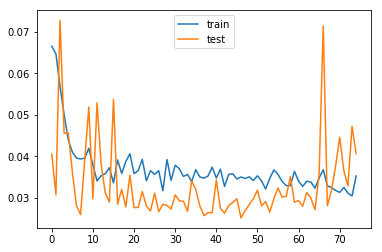

In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Compute the error

Compute the error (RMSE) for training and test. Previously, the examples suggest to invert the results from prediction to use the same units than in the source data.

In [9]:
# make a prediction
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling the prediction to the original values, for forecast
inv_yhat = concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling the actual test set, for actual values and compare results.
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_reshaped, test_X_reshaped[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.215


### Plot actual values and predicted values.

Plot the whoel series, and the predicted values for the test set.

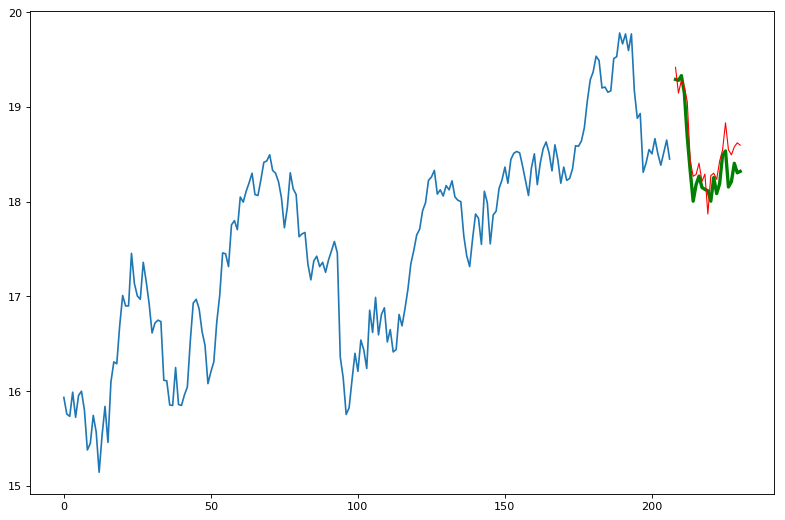

In [10]:
# Invert original training set to original values for plotting.
train_X_reshaped = train_X.reshape((train_X.shape[0], train_X.shape[2]))
inv_trainX = scaler.inverse_transform(train_X_reshaped)

# Plot
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
original_values = raw_dataset.values[:, 0]

train_values = numpy.empty_like(original_values)
train_values[:] = numpy.nan
train_values[0:len(inv_trainX)] = inv_trainX[:, 0]

test_values = numpy.empty_like(original_values)
test_values[:] = numpy.nan
test_values[(len(inv_trainX)+1):len(original_values)] = inv_y

predicted_values = numpy.empty_like(original_values)
predicted_values[:] = numpy.nan
predicted_values[(len(inv_trainX)+1):len(original_values)] = inv_yhat

#pyplot.plot(original_values)
actual_plot = plt.plot(train_values)
test_plot = plt.plot(test_values)
plt.setp(test_plot, color='g', linewidth=3.0)
prediction_plot = plt.plot(predicted_values)
plt.setp(prediction_plot, color='r', linewidth=1.0)
plt.show()

### Results Grid

              
     neurons | epochs | look_back | RMSE
    ---------|--------|-----------|-------
      46     | 25     | 1         | 0.161
      46     | 50     | 1         | 0.161
      46     | 75     | 1         | 0.215
      46     | 100    | 1         | 0.161
    